# Business Understanding

The goal of this project is to analyze the factors that influence vehicle pricing and build predictive models to estimate vehicle prices based on attributes like year, make, model, condition, and odometer.

### Business Questions
1. Which factors have the most significant impact on vehicle price? Understanding these factors can help sellers set competitive prices and buyers negotiate better deals.
2. How accurate can machine learning models be in predicting vehicle prices? Accurate predictions can optimize pricing strategy for dealers or resale platforms.
3. What actionable recommendations can we derive for improving vehicle sales?

### Success Criteria
- Build and evaluate multiple models to predict prices.
- Leverage statistical analysis and visualization to provide insights into trends in vehicle pricing factors.
- Present findings clearly to both technical and nontechnical stakeholders, with actionable and interpretable recommendations.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Data Cleaning and Organization

This section includes loading the dataset, preprocessing, handling of missing values, and necessary transformations to make the dataset ready for analysis and modeling.

In [17]:
# Load the dataset
try:
    df = pd.read_csv('vehicles.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'vehicles.csv' not found. Please make sure the file is in the correct location.")
    raise

# Preprocessing
# Drop unnecessary columns
df = df.drop(['id', 'VIN'], axis=1, errors='ignore')

# Remove 'cylinder' text and keep only numerical values
df['cylinders'] = df['cylinders'].str.extract('(\d+)')

# Fill NaN values in the 'cylinders' column with random assignments of 4, 6, or 8
random_fill_values = [4, 6, 8]
df['cylinders'] = df['cylinders'].fillna(pd.Series(np.random.choice(random_fill_values, size=len(df))))

# Convert the 'cylinders' column to numeric
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

# Separate target and features
# Assuming 'price' as the target variable for classification, we'll binarize the target into "high" and "low"
median_price = df['price'].median()
df['price_category'] = np.where(df['price'] > median_price, 1, 0)  # 1 = "high", 0 = "low"
df = df.drop(columns=['price'], errors='ignore')

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/yl/6g3mfqrj395djzvs6jsq74g40000gn/T/ipykernel_64725/3330270505.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['cylinders'] = df['cylinders'].str.extract('(\d+)')


Dataset loaded successfully.


# Descriptive and Inferential Statistics

In this section, we explore the dataset with statistical analysis to understand the relationships between features and prices.

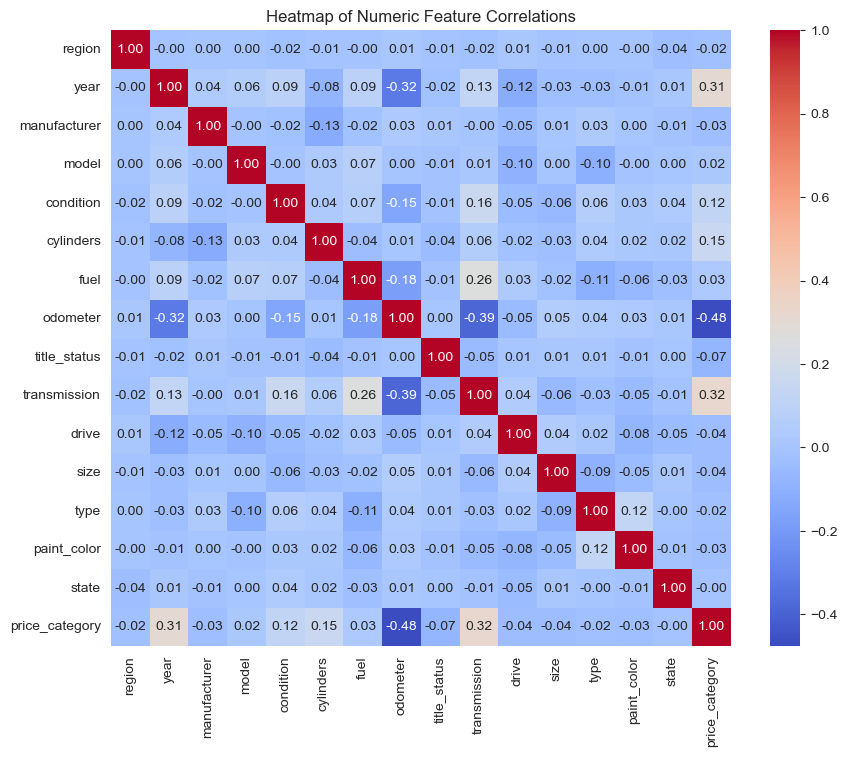

Pearson Correlation between Odometer and Price: -0.48 (p-value: 0.00e+00)
Pearson Correlation between Year and Price: 0.31 (p-value: 0.00e+00)
Pearson Correlation between Num of Cylinders and Price: 0.15 (p-value: 0.00e+00)


In [23]:
# Correlation analysis (Pearson and Spearman)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numeric_cols].corr()

# Display heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Numeric Feature Correlations")
plt.show()

# Example of inferential statistics - correlation between odometer and price
pearson_corr, p_value = pearsonr(df['odometer'], df['price_category'])
print(f"Pearson Correlation between Odometer and Price: {pearson_corr:.2f} (p-value: {p_value:.2e})")

# Example of inferential statistics - correlation between year and price
pearson_corr, p_value = pearsonr(df['year'], df['price_category'])
print(f"Pearson Correlation between Year and Price: {pearson_corr:.2f} (p-value: {p_value:.2e})")

# Example of inferential statistics - correlation between cylinder and price
pearson_corr, p_value = pearsonr(df['cylinders'], df['price_category'])
print(f"Pearson Correlation between Num of Cylinders and Price: {pearson_corr:.2f} (p-value: {p_value:.2e})")

# Regression Modeling

This section involves building multiple models to predict vehicle prices, hyperparameter tuning, and evaluating the models using cross-validation.

In [41]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=['price'])
y = df['price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression Grid Search
logistic_params = {'C': [0.1, 1, 10], 'solver': ['lbfgs'], 'penalty': ['l2']}
logistic_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=500), logistic_params, cv=3, scoring='accuracy', n_jobs=-1)
logistic_grid.fit(X_train, y_train)

# Random Forest Grid Search
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# XGBoost Grid Search
xgb_params = {'n_estimators': [100, 150], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2], 'subsample': [0.8, 1]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False), xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Evaluate best models using classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logistic_grid.predict(X_test)))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_grid.predict(X_test)))

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_grid.predict(X_test)))

# Cross-validation scores for best models
logistic_cv_scores = cross_val_score(logistic_grid.best_estimator_, X, y, cv=5, scoring='accuracy')
rf_cv_scores = cross_val_score(rf_grid.best_estimator_, X, y, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_grid.best_estimator_, X, y, cv=5, scoring='accuracy')

print("\nCross-validation Accuracy Scores:")
print(f"Logistic Regression CV Accuracy: {logistic_cv_scores.mean():.4f} ± {logistic_cv_scores.std():.4f}")
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74     42708
           1       0.74      0.74      0.74     42668

    accuracy                           0.74     85376
   macro avg       0.74      0.74      0.74     85376
weighted avg       0.74      0.74      0.74     85376

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     42708
           1       0.91      0.92      0.92     42668

    accuracy                           0.92     85376
   macro avg       0.92      0.92      0.92     85376
weighted avg       0.92      0.92      0.92     85376

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     42708
           1       0.85      0.89      0.87     42668

    accuracy                           0.87     85376
   macro avg    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite


Cross-validation Accuracy Scores:
Logistic Regression CV Accuracy: 0.7421 ± 0.0118
Random Forest CV Accuracy: 0.8122 ± 0.1044
XGBoost CV Accuracy: 0.7436 ± 0.0425


# Feature Importance

This section involves calculating the importance of each feature in the dataset to determine which ones have the most impact on customer buying decision-making.

Feature Importances:
         Feature  Importance
1           year    0.289773
7       odometer    0.164063
3          model    0.115514
0         region    0.059199
2   manufacturer    0.054018
14         state    0.053254
9   transmission    0.047506
12          type    0.043171
6           fuel    0.041777
5      cylinders    0.038848
10         drive    0.027462
13   paint_color    0.023832
4      condition    0.023687
11          size    0.010930
8   title_status    0.006966


/var/folders/yl/6g3mfqrj395djzvs6jsq74g40000gn/T/ipykernel_64725/2319711846.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


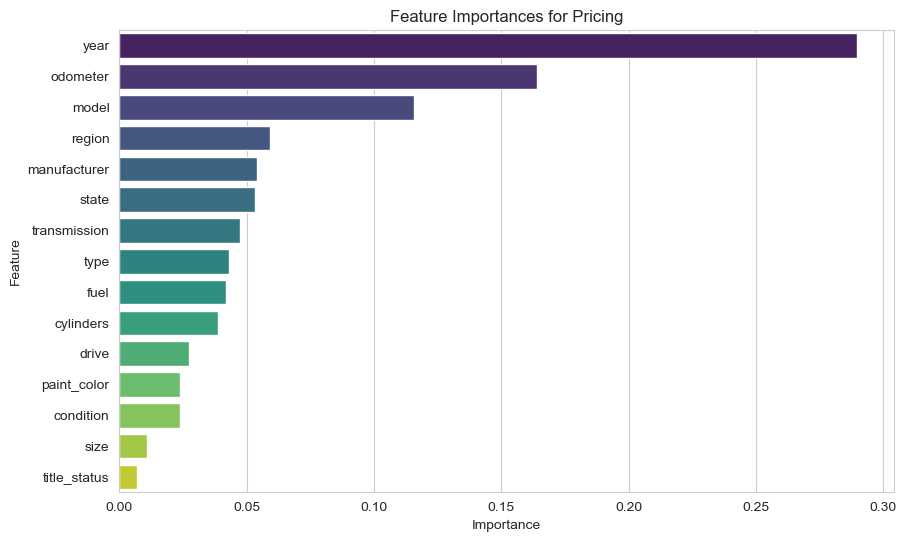

In [29]:
# Convert the 'price_category' back to 'price' for a regression problem
df['price'] = df['price_category']

# Drop 'price_category' since we are analyzing factors that affect pricing
df = df.drop(columns=['price_category'], errors='ignore')

# Define features and target
X = df.drop(columns=['price'])
y = df['price']

# Train a Random Forest Regressor to measure feature importance
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X, y)

# Get feature importance values
importance = rf_regressor.feature_importances_

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances for Pricing')
plt.show()

# Plots

This section involves building various plots to detail the relationship between the features.

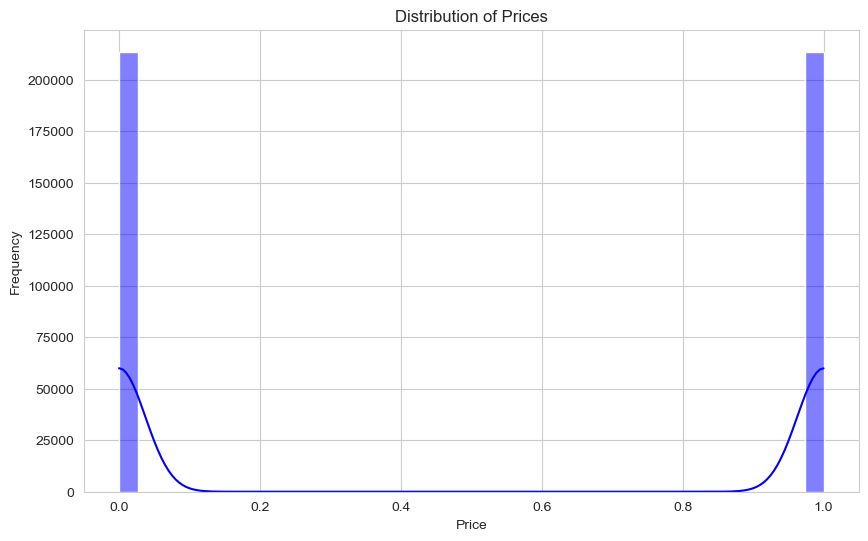

In [30]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, color='blue')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

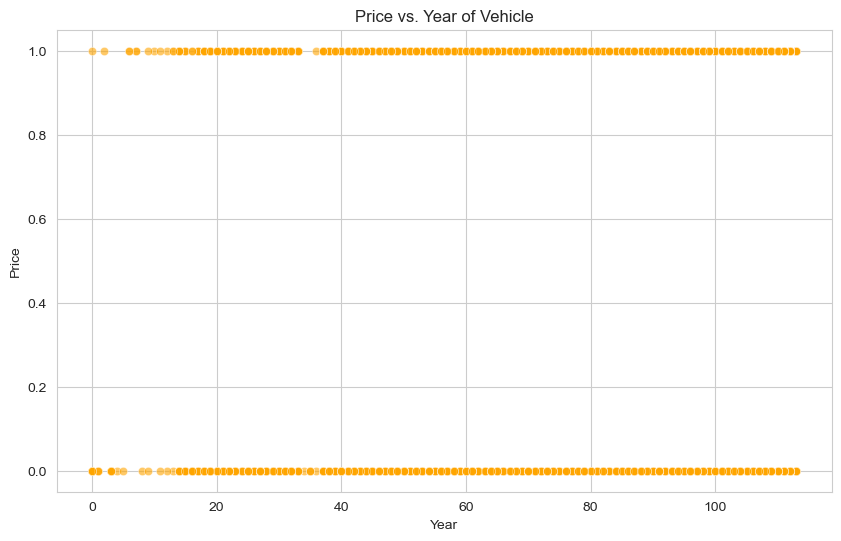

In [31]:
# Price vs. Year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=df, alpha=0.6, color='orange')
plt.title('Price vs. Year of Vehicle')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

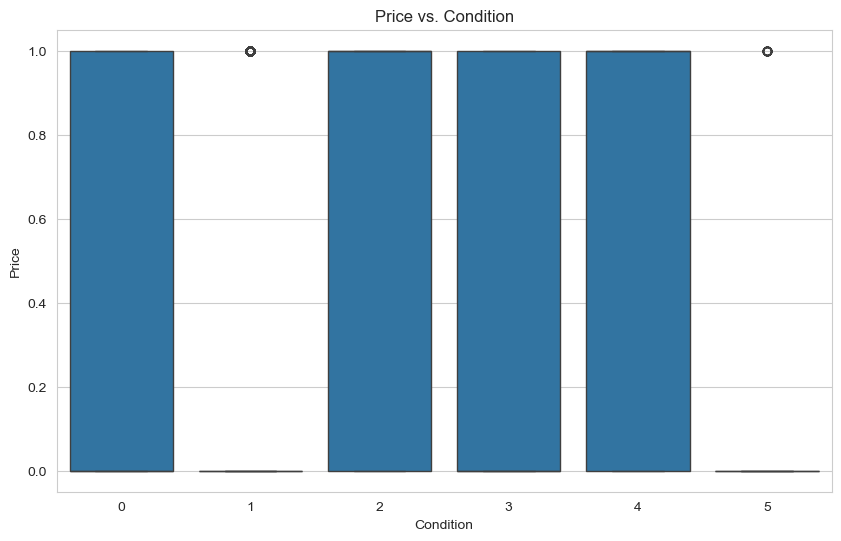

In [32]:
# Price vs. Condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=df)
plt.title('Price vs. Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()

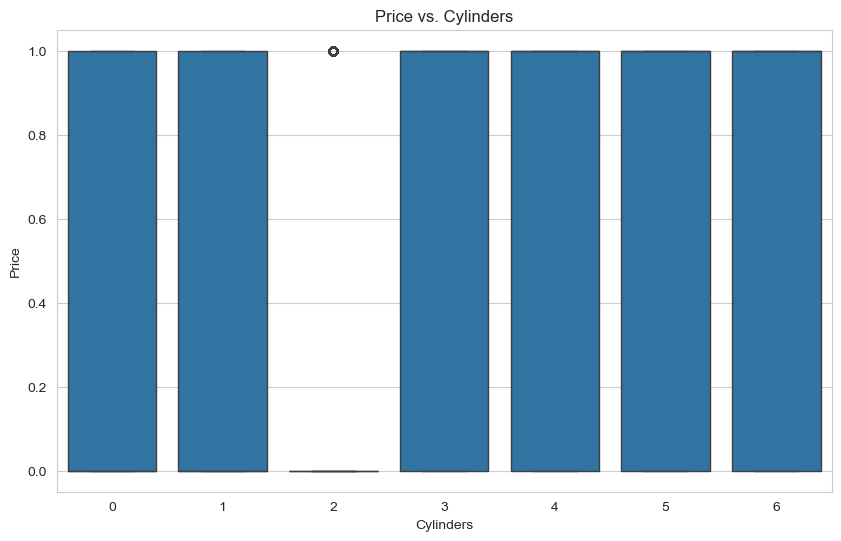

In [33]:
# Price vs. Cylinders
plt.figure(figsize=(10, 6))
sns.boxplot(x='cylinders', y='price', data=df)
plt.title('Price vs. Cylinders')
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.show()

# Future Pricing

This section involves building multiple models to predict vehicle prices in the future until 2150 and how much the price will fall each year.

    Year  Predicted_Price
0   2020    -19118.429196
1   2030    -27494.029081
2   2040    -35869.628967
3   2050    -44245.228853
4   2060    -52620.828738
5   2070    -60996.428624
6   2080    -69372.028510
7   2090    -77747.628396
8   2100    -86123.228281
9   2110    -94498.828167
10  2120   -102874.428053
11  2130   -111250.027939
12  2140   -119625.627824
13  2150   -128001.227710


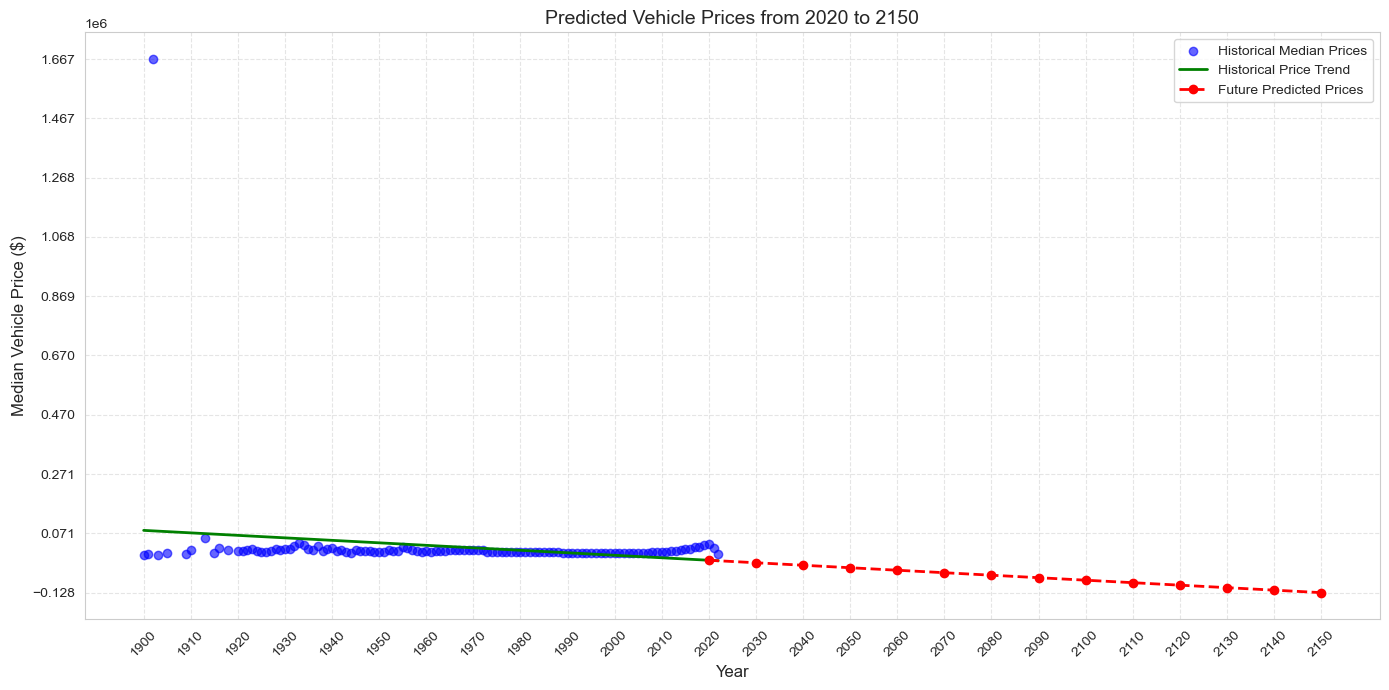

In [38]:
# Reload or ensure the original numeric prices exist:
df_original = pd.read_csv('vehicles.csv')

# Calculate median price per year correctly
average_price_per_year = df_original.groupby('year')['price'].median().reset_index()

# Prepare data correctly
X_years = average_price_per_year['year'].values.reshape(-1, 1)
y_prices = average_price_per_year['price'].values

# Train Linear Regression on aggregated median data
model = LinearRegression()
model.fit(X_years, y_prices)

# Predict future prices (2020–2150, incrementing every 10 years)
future_years = np.arange(2020, 2151, 10).reshape(-1, 1)
future_prices = model.predict(future_years)

# DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Year': future_years.flatten(),
    'Predicted_Price': future_prices.flatten()
})

# Print future predictions
print(future_predictions_df)

# Improved visualization
plt.figure(figsize=(14, 7))

# Historical median prices (scatter)
plt.scatter(X_years, y_prices, color='blue', alpha=0.6, label='Historical Median Prices')

# Historical trend line
plt.plot(X_years, model.predict(X_years), color='green', linewidth=2, label='Historical Price Trend')

# Future predictions clearly marked
plt.plot(future_years, future_prices, 'r--o', linewidth=2, label='Future Predicted Prices')

# Set clear intervals for X and Y axes
plt.xticks(np.arange(min(X_years.min(), 2020), 2160, 10), rotation=45)
plt.yticks(np.linspace(min(y_prices.min(), future_prices.min()),
                       max(y_prices.max(), future_prices.max()), 10))

# Axis labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Vehicle Price ($)', fontsize=12)
plt.title('Predicted Vehicle Prices from 2020 to 2150', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()